In [430]:
import os 
import sys
import time
import datetime
import collections
import itertools
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import scipy as sci

import matplotlib.pyplot as plt

In [431]:
train_part = pd.read_csv('alfabattle2_abattle_train_target.csv', parse_dates=['timestamp'])
train_part.drop(columns=['session_id'], inplace=True)
print(train_part.shape)
train_part.head(3)

(5065350, 3)


,client_pin,timestamp,multi_class_target
0,7cf9221322a0e2fdefb1b998b8f2ab29,2020-06-15 14:01:12,main_screen
1,5f16c0ab27a806fd08db3122921adf3a,2020-03-21 12:59:34,invest
2,ec868fc2b388293cf10e18ee9518d72f,2020-01-24 18:18:55,statement


In [432]:
test_part = pd.read_csv('alfabattle2_prediction_session_timestamp.csv', parse_dates=['timestamp'])
test_part['multi_class_target'] = 'need_to_predict'
print(test_part.shape)
test_part.head(3)

(79268, 3)


,client_pin,timestamp,multi_class_target
0,f0c674b2bb4dc64be607029271d706ec,2020-08-01 00:00:53,need_to_predict
1,90725b54ce77576883813d87749df6bd,2020-08-01 00:02:57,need_to_predict
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,2020-08-01 00:03:14,need_to_predict


In [433]:
sample_sub = pd.read_csv('alfabattle2_abattle_sample_prediction.csv')
print(sample_sub.shape)
sample_sub.head(3)

(79268, 2)


,client_pin,prediction
0,f0c674b2bb4dc64be607029271d706ec,credit_info
1,90725b54ce77576883813d87749df6bd,credit_info
2,eb0f82d74c7b7bd5eafbd5b5f8cb3e2a,own_transfer


In [434]:
train_part.multi_class_target.value_counts()

main_screen             2280763
statement                922569
credit_info              498698
own_transfer             290077
mobile_recharge          266485
phone_money_transfer     232911
card2card_transfer       193378
chat                     184775
card_recharge            138616
invest                    57078
Name: multi_class_target, dtype: int64

### Concatanation

In [435]:
train_part.multi_class_target.unique()

array(['main_screen', 'invest', 'statement', 'phone_money_transfer',
       'own_transfer', 'credit_info', 'chat', 'card2card_transfer',
       'mobile_recharge', 'card_recharge'], dtype=object)

In [470]:
Xy = pd.concat([train_part, test_part], axis=0).sort_values(['client_pin', 'timestamp'], ascending=[True, True])
Xy.reset_index(inplace=True, drop=True)
print(Xy.shape)
Xy.head(3)

(5144618, 3)


,client_pin,timestamp,multi_class_target
0,000033b6509acd1c8eb0d06ebd2e1de9,2020-02-02 22:31:04,statement
1,000033b6509acd1c8eb0d06ebd2e1de9,2020-02-19 18:37:26,main_screen
2,000033b6509acd1c8eb0d06ebd2e1de9,2020-02-22 23:18:45,main_screen


### Feature engineering

In [471]:
for k in range(1, 11, 1):
    print(k)
    Xy.loc[:, f'target_lag_{k}'] = Xy.groupby(['client_pin'])['multi_class_target'].shift(k)
    Xy.loc[:, f'time_diff_{k}'] = Xy.groupby(['client_pin'])['timestamp'].diff(k).astype('timedelta64[s]')

1
2
3
4
5
6
7
8
9
10


In [472]:
# (lala.loc[(lala.iloc[-1, 1] - lala.timestamp) < pd.Timedelta(value=31, unit='days'), 
#           'multi_class_target'] == 'mobile_recharge').any() in range()

In [473]:
Xy.columns

Index(['client_pin', 'timestamp', 'multi_class_target', 'target_lag_1',
       'time_diff_1', 'target_lag_2', 'time_diff_2', 'target_lag_3',
       'time_diff_3', 'target_lag_4', 'time_diff_4', 'target_lag_5',
       'time_diff_5', 'target_lag_6', 'time_diff_6', 'target_lag_7',
       'time_diff_7', 'target_lag_8', 'time_diff_8', 'target_lag_9',
       'time_diff_9', 'target_lag_10', 'time_diff_10'],
      dtype='object')

In [474]:
Xy.loc[:, 'sessions_count'] = Xy.groupby('client_pin').cumcount() + 1
Xy.loc[:, 'sessions_count'] = Xy.groupby('client_pin')['sessions_count'].shift(1)

for col in train_part.multi_class_target.unique():
    print(col)
    Xy.loc[:, f'{col}_count'] = Xy.groupby('client_pin').apply(
        lambda group: (group.multi_class_target == col).cumsum()
    ).reset_index().multi_class_target.shift(1).values
    Xy.loc[:, f'{col}_frac'] = Xy.loc[:, f'{col}_count'] / Xy.loc[:, 'sessions_count']

main_screen
invest
statement
phone_money_transfer
own_transfer
credit_info
chat
card2card_transfer
mobile_recharge
card_recharge


In [475]:
%%time
Xy_cleaned = Xy.groupby('client_pin').apply(lambda group: group.iloc[10:, 1:] \
                                            if group.shape[0] >= 11 else group.iloc[:, 1:]
                                           ).reset_index().drop(columns=['level_1'])
print(Xy_cleaned.shape)
Xy_cleaned.head(3)

(4490728, 44)
CPU times: user 3min 11s, sys: 6.26 s, total: 3min 17s
Wall time: 3min 17s


,client_pin,timestamp,multi_class_target,target_lag_1,time_diff_1,target_lag_2,time_diff_2,target_lag_3,time_diff_3,target_lag_4,...,credit_info_count,credit_info_frac,chat_count,chat_frac,card2card_transfer_count,card2card_transfer_frac,mobile_recharge_count,mobile_recharge_frac,card_recharge_count,card_recharge_frac
0,000033b6509acd1c8eb0d06ebd2e1de9,2020-03-12 17:19:50,main_screen,main_screen,7920.0,main_screen,169343.0,main_screen,280180.0,main_screen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000033b6509acd1c8eb0d06ebd2e1de9,2020-03-13 14:41:04,main_screen,main_screen,76874.0,main_screen,84794.0,main_screen,246217.0,main_screen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000033b6509acd1c8eb0d06ebd2e1de9,2020-03-13 16:06:36,main_screen,main_screen,5132.0,main_screen,82006.0,main_screen,89926.0,main_screen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [476]:
Xy_cleaned.loc[:, 'hour'] = Xy_cleaned.timestamp.dt.hour

In [477]:
Xy_cleaned.drop(columns=['timestamp'], inplace=True)
Xy_cleaned.head(3)

,client_pin,multi_class_target,target_lag_1,time_diff_1,target_lag_2,time_diff_2,target_lag_3,time_diff_3,target_lag_4,time_diff_4,...,credit_info_frac,chat_count,chat_frac,card2card_transfer_count,card2card_transfer_frac,mobile_recharge_count,mobile_recharge_frac,card_recharge_count,card_recharge_frac,hour
0,000033b6509acd1c8eb0d06ebd2e1de9,main_screen,main_screen,7920.0,main_screen,169343.0,main_screen,280180.0,main_screen,432138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
1,000033b6509acd1c8eb0d06ebd2e1de9,main_screen,main_screen,76874.0,main_screen,84794.0,main_screen,246217.0,main_screen,357054.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
2,000033b6509acd1c8eb0d06ebd2e1de9,main_screen,main_screen,5132.0,main_screen,82006.0,main_screen,89926.0,main_screen,251349.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16


In [478]:
%%time
Xy_cleaned_train_val = Xy_cleaned.groupby('client_pin').apply(lambda group: group.iloc[:-1, 1:]).reset_index()
Xy_cleaned_train_val.drop(columns=['level_1'], inplace=True)

Xy_cleaned_train = Xy_cleaned.groupby('client_pin').apply(lambda group: group.iloc[:-2, 1:]).reset_index()
Xy_cleaned_train.drop(columns=['level_1'], inplace=True)

Xy_cleaned_val = Xy_cleaned.groupby('client_pin').apply(lambda group: group.iloc[-2, 1:] \
                                                        if group.shape[0] > 1 else None).reset_index()

Xy_cleaned_test = Xy_cleaned.groupby('client_pin').apply(lambda group: group.iloc[-1, 1:]).reset_index()

Xy_cleaned_train_val.shape, Xy_cleaned_train.shape, Xy_cleaned_val.shape, Xy_cleaned_test.shape

((4411460, 44), (4333574, 44), (79268, 44), (79268, 44))

In [479]:
Xy_cleaned_val = Xy_cleaned_val.loc[Xy_cleaned_val.client_pin.isin(Xy_cleaned_train.client_pin.unique())]
Xy_cleaned_val.shape

(74943, 44)

In [480]:
X_train_val, y_train_val = Xy_cleaned_train_val.drop(columns=['multi_class_target']), Xy_cleaned_train_val['multi_class_target']
X_test, y_test = Xy_cleaned_test.drop(columns=['multi_class_target']), Xy_cleaned_test['multi_class_target']

X_train, y_train = Xy_cleaned_train.drop(columns=['multi_class_target']), Xy_cleaned_train['multi_class_target']
X_val, y_val = Xy_cleaned_val.drop(columns=['multi_class_target']), Xy_cleaned_val['multi_class_target']

In [481]:
cat_features = ['client_pin'] + [f'target_lag_{k}' for k in range(1, 11, 1)] + ['hour']
num_features = [f'time_diff_{k}' for k in range(1, 11, 1)]

In [519]:
for data in [X_train_val, X_test, X_train, X_val]:
    data[cat_features] = data[cat_features].fillna(value='nan_category')
    data[num_features] = data[num_features].fillna(value=50*10**6)
    data.loc[:, 'sessions_count':'card_recharge_frac'] = data.loc[:, 'sessions_count':'card_recharge_frac'].fillna(0)
    data['sessions_count'] = data['sessions_count'].astype('int')
    data['hour'] = data['hour'].astype('int')
    data.drop(columns=['time_diff_4', 'time_diff_5', 'time_diff_6', 'time_diff_7', 'time_diff_8', 'time_diff_9', 'time_diff_10', 
                       'main_screen_count', 'invest_count', 'statement_count', 'phone_money_transfer_count', 'own_transfer_count', 
                       'credit_info_count', 'chat_count', 'card2card_transfer_count', 'mobile_recharge_count', 'card_recharge_count'], 
              inplace=True)

In [520]:
X_train.columns

Index(['client_pin', 'target_lag_1', 'time_diff_1', 'target_lag_2',
       'time_diff_2', 'target_lag_3', 'time_diff_3', 'target_lag_4',
       'target_lag_5', 'target_lag_6', 'target_lag_7', 'target_lag_8',
       'target_lag_9', 'target_lag_10', 'sessions_count', 'main_screen_frac',
       'invest_frac', 'statement_frac', 'phone_money_transfer_frac',
       'own_transfer_frac', 'credit_info_frac', 'chat_frac',
       'card2card_transfer_frac', 'mobile_recharge_frac', 'card_recharge_frac',
       'hour'],
      dtype='object')

### Models

In [488]:
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

In [548]:
%pip install hyperopt

     |████████████████████████████████| 965 kB 3.6 MB/s 
     |████████████████████████████████| 829 kB 13.1 MB/s 
     |████████████████████████████████| 1.6 MB 18.7 MB/s 
     |████████████████████████████████| 14.5 MB 20.6 MB/s 
     |████████████████████████████████| 25.9 MB 82.2 MB/s 
     |████████████████████████████████| 68 kB 7.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=493275 sha256=d3598afbf0edf2fcc4c8a6544408e9a1814f1d1ad0ee1e13b045cdceb65ed803
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dvc 1.4.0 requires networkx<2.5,>=2.1, but you have networkx 2.5 which is incompatible.
cloud-ml 0.0.1 requires tqdm<=4.53.0,>=4.45.0, but you have tqdm 4.55.0 which is incompatible.
You should

In [550]:
from hyperopt import fmin, tpe, hp

In [553]:
#!L
scores = {}

def hyperopt_opt_score(params):
    n_estims, depth, reg, eta = params['n_estimators'], params['depth'], params['l2_leaf_reg'], params['eta']
                                                 
    model = CatBoostClassifier(allow_writing_files=False, verbose=False, cat_features=cat_features,
                               task_type='GPU', devices='0-7', random_seed=42,
                               n_estimators=n_estims, depth=depth, l2_leaf_reg=reg, eta=eta).fit(X_train, y_train)
    
    f_scores = [round(f1_score(y_true=y_train, y_pred=model.predict(X_train), average='macro'), 3),
                round(f1_score(y_true=y_val, y_pred=model.predict(X_val), average='macro'), 3)]
    
    scores[f'n = {n_estims}, depth = {depth}, reg = {reg}, eta = {eta}'] = f_scores
    
    return -f_scores[1]

cb_space = {
    'eta': hp.uniform('eta', 0.01, 0.50),
    'depth': hp.choice('depth', np.arange(3, 11, 1)),
    'n_estimators': hp.choice('n_estimators', np.arange(200, 700, 300)),
    'l2_leaf_reg': hp.choice('l2_leaf_reg', np.arange(1, 14, 2))
}

best_params = fmin(fn=hyperopt_opt_score, space=cb_space, algo=tpe.suggest, max_evals=100)

best_params['n_estimators'] = np.arange(200, 700, 300)[best_params['n_estimators']]
best_params['l2_leaf_reg'] = np.arange(1, 14, 2)[best_params['l2_leaf_reg']]
best_params['depth'] = np.arange(3, 11, 1)[best_params['depth']]

print(best_params)

100%|██████████| 100/100 [4:36:44<00:00, 166.05s/trial, best loss: -0.392]
{'depth': 7, 'eta': 0.11472179499884913, 'l2_leaf_reg': 3, 'n_estimators': 500}


In [552]:
scores

{'n = 200, depth = 9, reg = 5, eta = 0.24870174063900347': [0.471, 0.387],
 'n = 200, depth = 5, reg = 1, eta = 0.4268275728738296': [0.452, 0.382],
 'n = 200, depth = 4, reg = 1, eta = 0.2932920803631124': [0.458, 0.388],
 'n = 800, depth = 6, reg = 9, eta = 0.2067108278915939': [0.467, 0.387],
 'n = 200, depth = 3, reg = 9, eta = 0.04622035625407361': [0.43, 0.372],
 'n = 200, depth = 10, reg = 3, eta = 0.34372448525829297': [0.487, 0.385],
 'n = 500, depth = 7, reg = 11, eta = 0.07889868860026988': [0.463, 0.391]}

In [561]:
sorted(scores.items(), key=lambda item: (item[1][1], item[1][0]), reverse=True)[:25]

[('n = 500, depth = 7, reg = 3, eta = 0.11472179499884913', [0.465, 0.392]),
 ('n = 500, depth = 10, reg = 7, eta = 0.10934896188374668', [0.481, 0.391]),
 ('n = 500, depth = 10, reg = 9, eta = 0.08203854667797023', [0.476, 0.391]),
 ('n = 200, depth = 8, reg = 13, eta = 0.26458108971531097', [0.466, 0.391]),
 ('n = 200, depth = 9, reg = 9, eta = 0.15222413546175778', [0.466, 0.391]),
 ('n = 500, depth = 7, reg = 3, eta = 0.11641256505320632', [0.466, 0.391]),
 ('n = 500, depth = 7, reg = 3, eta = 0.12463405519774652', [0.465, 0.391]),
 ('n = 200, depth = 9, reg = 13, eta = 0.13903207065473105', [0.464, 0.391]),
 ('n = 500, depth = 7, reg = 3, eta = 0.08972417502740215', [0.464, 0.391]),
 ('n = 500, depth = 6, reg = 3, eta = 0.12414057623664643', [0.463, 0.391]),
 ('n = 500, depth = 7, reg = 3, eta = 0.06923871033848265', [0.462, 0.391]),
 ('n = 200, depth = 7, reg = 3, eta = 0.10946218729044759', [0.459, 0.391]),
 ('n = 500, depth = 10, reg = 9, eta = 0.15229889120461548', [0.486, 0.3

In [563]:
sorted(scores.items(), key=lambda item: (item[1][0]), reverse=False)[10:25]

[('n = 200, depth = 5, reg = 13, eta = 0.07628154070380641', [0.452, 0.388]),
 ('n = 200, depth = 3, reg = 13, eta = 0.16570058601622079', [0.452, 0.386]),
 ('n = 500, depth = 3, reg = 9, eta = 0.07475729829399534', [0.453, 0.389]),
 ('n = 200, depth = 4, reg = 9, eta = 0.1339136677266152', [0.454, 0.387]),
 ('n = 500, depth = 4, reg = 3, eta = 0.46762459059829764', [0.454, 0.381]),
 ('n = 200, depth = 3, reg = 5, eta = 0.45295887129279155', [0.455, 0.386]),
 ('n = 500, depth = 6, reg = 3, eta = 0.03809282307208853', [0.457, 0.389]),
 ('n = 500, depth = 3, reg = 11, eta = 0.14980171774921197', [0.457, 0.387]),
 ('n = 200, depth = 5, reg = 7, eta = 0.167921552319169', [0.457, 0.389]),
 ('n = 200, depth = 7, reg = 3, eta = 0.09726916762711227', [0.458, 0.389]),
 ('n = 500, depth = 6, reg = 3, eta = 0.04886202196141133', [0.458, 0.389]),
 ('n = 500, depth = 3, reg = 7, eta = 0.19996069774615133', [0.458, 0.39]),
 ('n = 200, depth = 5, reg = 13, eta = 0.18455865112127878', [0.458, 0.388]),

In [564]:
#!L
model = CatBoostClassifier(allow_writing_files=False, verbose=100, cat_features=cat_features, random_seed=42,
                           task_type='GPU', devices='0-7', n_estimators=500, depth=7, l2_leaf_reg=3, eta=0.11)
model.fit(X_train_val, y_train_val)

0:	learn: 2.0794009	total: 102ms	remaining: 50.7s
100:	learn: 1.1285408	total: 9.77s	remaining: 38.6s
200:	learn: 1.1180778	total: 19.3s	remaining: 28.8s
300:	learn: 1.1129051	total: 28.9s	remaining: 19.1s
400:	learn: 1.1094268	total: 38.2s	remaining: 9.44s
499:	learn: 1.1067828	total: 47.6s	remaining: 0us


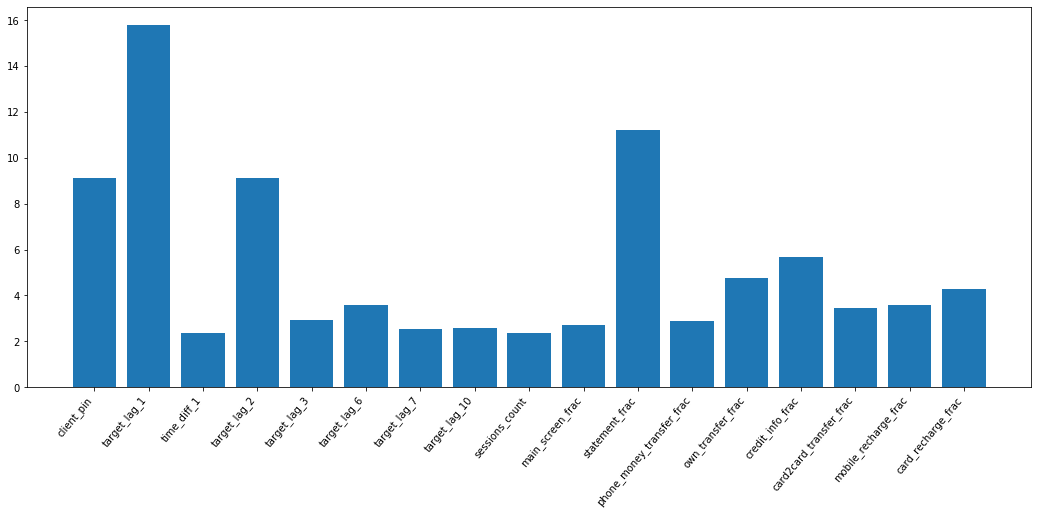

In [571]:
plt.figure(figsize=(18, 7))
plt.bar(X_test.columns[model.feature_importances_ > 2], model.feature_importances_[model.feature_importances_ > 2])
plt.xticks(rotation=50, ha='right')
plt.show()

In [566]:
X_test.columns[model.feature_importances_ < 2]

Index(['time_diff_2', 'time_diff_3', 'target_lag_4', 'target_lag_5',
       'target_lag_8', 'target_lag_9', 'invest_frac', 'chat_frac', 'hour'],
      dtype='object')

In [567]:
print('F1 на обучении:', 
        round(f1_score(
            y_true=y_train_val,
            y_pred=model.predict(X_train_val),
            average='macro'
        ), 3)
     )

F1 на обучении: 0.463


In [572]:
# сохраняем модель
import joblib
joblib.dump(value=model, filename='catboost_model_5.pkl')

['catboost_model_5.pkl']

In [573]:
sample_sub['client_pin'] = X_test.client_pin.values
sample_sub['prediction'] = model.predict(X_test)

In [574]:
sample_sub.to_csv('alfaboosters_5.csv', index=False)

### Bagging

In [576]:
alfa1, alfa2, alfa3 = pd.read_csv('alfaboosters_1.csv', header=0), pd.read_csv('alfaboosters_4.csv', header=0), \
                                                                        pd.read_csv('alfaboosters_5.csv', header=0)

In [580]:
alfa1.prediction == alfa2.prediction

0         True
1         True
2         True
3         True
4        False
         ...  
79263     True
79264     True
79265    False
79266     True
79267     True
Name: prediction, Length: 79268, dtype: bool

In [584]:
a = pd.concat([alfa2[alfa2.prediction == alfa3.prediction], alfa1[alfa1.prediction == alfa2.prediction], 
               alfa3[alfa1.prediction == alfa3.prediction]], axis=0).drop_duplicates()

In [588]:
a = alfa1.merge(a, how='outer', on='client_pin')

In [590]:
a.prediction_x = a.prediction_x.fillna(a.prediction_y)

In [595]:
a.rename(columns={'prediction_x': 'prediction'}).drop(columns='prediction_y').to_csv('alfaboosters_6.csv', index=False)

In [597]:
sample_sub['prediction'] = a.rename(columns={'prediction_x': 'prediction'}).drop(columns='prediction_y').prediction.values
sample_sub.to_csv('alfaboosters_6.csv', index=False)